## Importing the libraries

In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import math
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


In [2]:
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# 3. Movie Genre Classification using FeedFroward NNs

1. Download the dataset of HW4 (Click Here!), which consists of three files: train.txt, validation.txt and test.txt. Each line of a file contains a movie name, movie genre and a short description of the movie. The task is to classify movie genre using the given description. Read the dataset and report the data statistics (number of classes, number of instances in each class) for train, validation and test sets.

### 3.a Data Statistics

In [4]:
train_df = pd.read_csv('hw04_data/train.csv')
test_df = pd.read_csv('hw04_data/test.csv')
validation_df = pd.read_csv('hw04_data/validation.csv')

In [5]:
def print_data_statistics(dataframe, name):
    print("---------------------"+ color.BOLD + name + color.END+"---------------------")
    print(dataframe.genre.value_counts())
    dataframe['genre'].value_counts().plot(kind='bar')
    plt.title(f"{name} dataset distribution")
    plt.show()

---------------------Train---------------------
drama          5483
documentary    4861
comedy         3896
horror         2104
thriller       1568
action         1312
Name: genre, dtype: int64


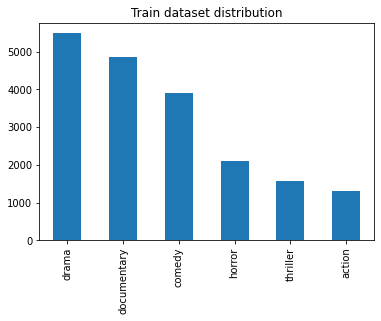

---------------------Test---------------------
drama          3012
documentary    2716
comedy         2241
horror         1102
thriller        795
action          657
Name: genre, dtype: int64


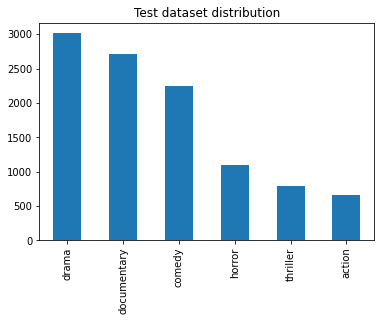

---------------------Validation---------------------
drama          3012
documentary    2716
comedy         2241
horror         1102
thriller        795
action          657
Name: genre, dtype: int64


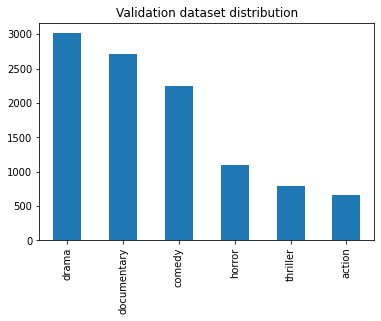

In [6]:
print_data_statistics(train_df,"Train")
print_data_statistics(test_df,"Test")
print_data_statistics(validation_df,"Validation")

### 3.b Feed Forward Neural Network Implementation

2. Implement a Feed Forward Neural Network with n layers using PyTorch that takes as input the number of layers n and the number of nodes in each layer, Sl for l ∈ {1,...,n}. The loss function must be the cross-entropy loss. Use an activation function of your choice and also choose optimizer, learning rate, batch size, and epoch.

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder().fit(train_df.genre)

train_features = torch.tensor(train_df[train_df.columns[:-1]].values)
train_target = torch.tensor(label_encoder.transform(train_df['genre']))

test_features = torch.tensor(test_df[test_df.columns[:-1]].values)
test_target = torch.tensor(label_encoder.transform(test_df.genre.values))

validation_features = torch.tensor(validation_df[validation_df.columns[:-1]].values)
validation_target = torch.tensor(label_encoder.transform(validation_df.genre.values))

In [8]:
train_dataset = TensorDataset(train_features, train_target)
val_dataset = TensorDataset(test_features, test_target)
test_dataset = TensorDataset(validation_features, validation_target)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [9]:
def implement_neural_network(no_layers, nodes_in_layer, activation_function, learning_rate, no_epoch, train_loader, val_loader):
    no_classes = train_loader.dataset.tensors[1].unique().shape[0]
    
    class NeuralNetwork(nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = nn.ModuleList()
            for i in range(no_layers):
                if i==0:
                    self.layers.append(nn.Linear(train_loader.dataset.tensors[0].shape[1] ,nodes_in_layer[i], dtype=torch.float64))
                else:
                    self.layers.append(nn.Linear(nodes_in_layer[i-1], nodes_in_layer[i], dtype=torch.float64))
            self.layers.append(nn.Linear(nodes_in_layer[i-1], no_classes, dtype=torch.float64))
        
        def forward(self, X):
            x = X
            for layer in self.layers[:-1]:
                x = activation_function(layer(x))
            x = self.layers[-1](x)

            return x
        
    criterion = nn.CrossEntropyLoss()
    model = NeuralNetwork()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(model.layers)
    
    train_losses = []
    val_losses = []
    best_val_loss = 99999999.0
    best_model = None
    
    for epoch in range(no_epoch):
        running_train_loss = 0.0
        running_val_loss = 0.0
        model.train()
        for i, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        train_losses.append(running_train_loss / len(train_loader))
        model.eval()
        with torch.no_grad():
            for i, (data, labels) in enumerate(val_loader):
                outputs = model(data)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
            val_losses.append(running_val_loss / len(val_loader))
        print(f"Epoch {epoch+1}: Train Loss {train_losses[-1]:.4f}, Val Loss {val_losses[-1]:.4f}")
        
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            print("Found a new model with the lowest validation loss")
            best_model = copy.deepcopy(model)
        
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    return best_model

In [10]:
def eval_neural_network(model, test_loader, name, return_arg = False):
    model.eval()
    with torch.no_grad():
        # for data, labels in test_loader
        outputs = model(test_loader.dataset.tensors[0])
        labels = test_loader.dataset.tensors[1]
        _, predicted = torch.max(outputs.data, 1)

        cm = metrics.confusion_matrix(predicted,labels)
        accuracies_in_class = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).diagonal()
        if return_arg:
            return np.round(metrics.accuracy_score(predicted,labels),3), accuracies_in_class
        else:
            print("---------------------"+ color.BOLD + name + color.END+"---------------------")
            print("\nMean Accuracy Score across all categories:", np.round(metrics.accuracy_score(predicted,labels),3))
            print("\n")
            for i in range(len(accuracies_in_class)):
                print("Accuracy for class "+ label_encoder.inverse_transform([i])[0] + " : "+ color.BOLD + str(np.round(accuracies_in_class[i],3)) + color.END)
            print("\n")
            print(metrics.classification_report(predicted, labels))        

In [11]:
activation = nn.ReLU()

### 3.c Model 1

3. Train the NN with one hidden layer having 64 neurons on the training dataset. Use the val- idation dataset during training to select the best performing model. Evaluate the best model on the test dataset. Report the mean classification accuracy and mean per class accuracy for train set, validation set and test set. Also, plot training and validation losses with respect to epoch in the same figure.

ModuleList(
  (0): Linear(in_features=300, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=6, bias=True)
)
Epoch 1: Train Loss 1.6268, Val Loss 1.5654
Found a new model with the lowest validation loss
Epoch 2: Train Loss 1.4661, Val Loss 1.4157
Found a new model with the lowest validation loss
Epoch 3: Train Loss 1.3107, Val Loss 1.2619
Found a new model with the lowest validation loss
Epoch 4: Train Loss 1.2148, Val Loss 1.2180
Found a new model with the lowest validation loss
Epoch 5: Train Loss 1.1586, Val Loss 1.1657
Found a new model with the lowest validation loss
Epoch 6: Train Loss 1.1100, Val Loss 1.1698
Epoch 7: Train Loss 1.0806, Val Loss 1.0759
Found a new model with the lowest validation loss
Epoch 8: Train Loss 1.0577, Val Loss 1.0933
Epoch 9: Train Loss 1.0350, Val Loss 1.1087
Epoch 10: Train Loss 1.0210, Val Loss 1.0415
Found a new model with the lowest validation loss
Epoch 11: Train Loss 1.0095, Val Loss 1.0485
Epoch 12: Train Loss 0.9992, Val L

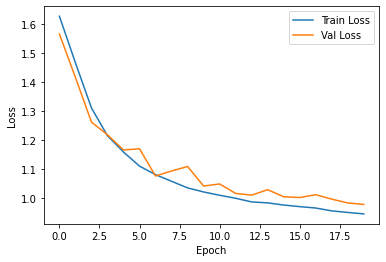

In [12]:
model1 = implement_neural_network(no_layers=1, nodes_in_layer=[64], activation_function=activation, 
                                  learning_rate=0.001, no_epoch=20, train_loader=train_loader, val_loader=val_loader)

In [13]:
eval_neural_network(model1, train_loader, "Training Metrics")
eval_neural_network(model1, test_loader, "Testing Metrics")
eval_neural_network(model1, val_loader, "Validation Metrics")

---------------------Training Metrics---------------------

Mean Accuracy Score across all categories: 0.651


Accuracy for class action : 0.624
Accuracy for class comedy : 0.638
Accuracy for class documentary : 0.798
Accuracy for class drama : 0.553
Accuracy for class horror : 0.729
Accuracy for class thriller : 0.435


              precision    recall  f1-score   support

           0       0.45      0.62      0.52       950
           1       0.62      0.64      0.63      3780
           2       0.84      0.80      0.82      5116
           3       0.73      0.55      0.63      7203
           4       0.60      0.73      0.66      1724
           5       0.12      0.43      0.19       451

    accuracy                           0.65     19224
   macro avg       0.56      0.63      0.57     19224
weighted avg       0.70      0.65      0.67     19224

---------------------Testing Metrics---------------------

Mean Accuracy Score across all categories: 0.643


Accuracy for class actio

### 3.d Model 2

4. Train the NN with two hidden layers having 64 neurons each on the training dataset. Use the validation dataset during training to select the best performing model. Evaluate the best model on the test dataset. Report the mean classification accuracy and mean per class accu- racy for train set, validation set and test set. Also, plot training and validation losses with respect to epoch in the same figure.

ModuleList(
  (0): Linear(in_features=300, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=64, bias=True)
  (2): Linear(in_features=64, out_features=6, bias=True)
)
Epoch 1: Train Loss 1.5902, Val Loss 1.4143
Found a new model with the lowest validation loss
Epoch 2: Train Loss 1.3280, Val Loss 1.2514
Found a new model with the lowest validation loss
Epoch 3: Train Loss 1.2082, Val Loss 1.3239
Epoch 4: Train Loss 1.1355, Val Loss 1.1083
Found a new model with the lowest validation loss
Epoch 5: Train Loss 1.1076, Val Loss 1.1866
Epoch 6: Train Loss 1.0944, Val Loss 1.0742
Found a new model with the lowest validation loss
Epoch 7: Train Loss 1.0691, Val Loss 1.1095
Epoch 8: Train Loss 1.0559, Val Loss 1.0758
Epoch 9: Train Loss 1.0420, Val Loss 1.1052
Epoch 10: Train Loss 1.0133, Val Loss 1.0903
Epoch 11: Train Loss 0.9861, Val Loss 1.0516
Found a new model with the lowest validation loss
Epoch 12: Train Loss 0.9782, Val Loss 1.0780
Epoch 13: Train Loss 0.9667, Va

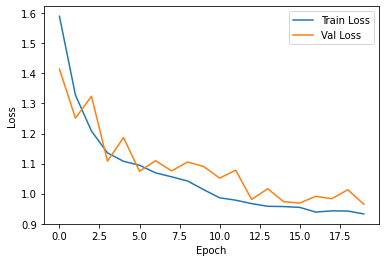

In [14]:
model2 = implement_neural_network(no_layers=2,nodes_in_layer=[64,64], activation_function=activation,
                                  learning_rate=0.001,no_epoch=20, train_loader=train_loader, val_loader=val_loader)

In [15]:
eval_neural_network(model2, train_loader, "Training Metrics")
eval_neural_network(model2, test_loader, "Testing Metrics")
eval_neural_network(model2, val_loader, "Validation Metrics")

---------------------Training Metrics---------------------

Mean Accuracy Score across all categories: 0.662


Accuracy for class action : 0.703
Accuracy for class comedy : 0.627
Accuracy for class documentary : 0.783
Accuracy for class drama : 0.61
Accuracy for class horror : 0.606
Accuracy for class thriller : 0.328


              precision    recall  f1-score   support

           0       0.34      0.70      0.45       627
           1       0.71      0.63      0.66      4391
           2       0.85      0.78      0.82      5306
           3       0.67      0.61      0.64      5996
           4       0.78      0.61      0.68      2718
           5       0.04      0.33      0.07       186

    accuracy                           0.66     19224
   macro avg       0.56      0.61      0.55     19224
weighted avg       0.73      0.66      0.69     19224

---------------------Testing Metrics---------------------

Mean Accuracy Score across all categories: 0.641


Accuracy for class action

### 3.e Model 3

5. Repeat (c) using 128 neurons for the hidden layer.

ModuleList(
  (0): Linear(in_features=300, out_features=128, bias=True)
  (1): Linear(in_features=128, out_features=6, bias=True)
)
Epoch 1: Train Loss 1.5706, Val Loss 1.4917
Found a new model with the lowest validation loss
Epoch 2: Train Loss 1.3277, Val Loss 1.2789
Found a new model with the lowest validation loss
Epoch 3: Train Loss 1.2011, Val Loss 1.2036
Found a new model with the lowest validation loss
Epoch 4: Train Loss 1.1275, Val Loss 1.1116
Found a new model with the lowest validation loss
Epoch 5: Train Loss 1.0911, Val Loss 1.0841
Found a new model with the lowest validation loss
Epoch 6: Train Loss 1.0529, Val Loss 1.0744
Found a new model with the lowest validation loss
Epoch 7: Train Loss 1.0308, Val Loss 1.1378
Epoch 8: Train Loss 1.0217, Val Loss 1.1450
Epoch 9: Train Loss 0.9962, Val Loss 1.0142
Found a new model with the lowest validation loss
Epoch 10: Train Loss 0.9816, Val Loss 1.0601
Epoch 11: Train Loss 0.9802, Val Loss 0.9997
Found a new model with the lowes

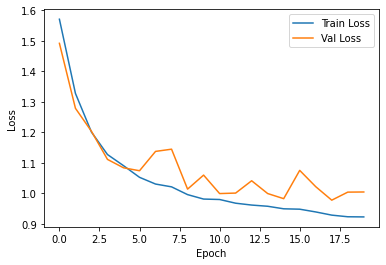

In [16]:
model3 = implement_neural_network(no_layers=1, nodes_in_layer=[128], activation_function=activation, 
                                  learning_rate=0.001, no_epoch=20, train_loader=train_loader, val_loader=val_loader)

In [17]:
eval_neural_network(model3, train_loader, "Training Metrics")
eval_neural_network(model3, test_loader, "Testing Metrics")
eval_neural_network(model3, val_loader, "Validation Metrics")

---------------------Training Metrics---------------------

Mean Accuracy Score across all categories: 0.654


Accuracy for class action : 0.654
Accuracy for class comedy : 0.651
Accuracy for class documentary : 0.787
Accuracy for class drama : 0.548
Accuracy for class horror : 0.729
Accuracy for class thriller : 0.537


              precision    recall  f1-score   support

           0       0.40      0.65      0.49       798
           1       0.63      0.65      0.64      3747
           2       0.85      0.79      0.82      5271
           3       0.73      0.55      0.63      7319
           4       0.62      0.73      0.67      1774
           5       0.11      0.54      0.18       315

    accuracy                           0.65     19224
   macro avg       0.56      0.65      0.57     19224
weighted avg       0.71      0.65      0.67     19224

---------------------Testing Metrics---------------------

Mean Accuracy Score across all categories: 0.641


Accuracy for class actio

### 3.f Model 4

6. Repeat (d) using 128 neurons for both the hidden layers.  

ModuleList(
  (0): Linear(in_features=300, out_features=128, bias=True)
  (1): Linear(in_features=128, out_features=128, bias=True)
  (2): Linear(in_features=128, out_features=6, bias=True)
)
Epoch 1: Train Loss 1.5600, Val Loss 1.3619
Found a new model with the lowest validation loss
Epoch 2: Train Loss 1.2899, Val Loss 1.2331
Found a new model with the lowest validation loss
Epoch 3: Train Loss 1.1655, Val Loss 1.2098
Found a new model with the lowest validation loss
Epoch 4: Train Loss 1.1120, Val Loss 1.1136
Found a new model with the lowest validation loss
Epoch 5: Train Loss 1.0696, Val Loss 1.1323
Epoch 6: Train Loss 1.0262, Val Loss 1.0412
Found a new model with the lowest validation loss
Epoch 7: Train Loss 1.0147, Val Loss 1.0093
Found a new model with the lowest validation loss
Epoch 8: Train Loss 1.0023, Val Loss 1.0402
Epoch 9: Train Loss 0.9867, Val Loss 1.0756
Epoch 10: Train Loss 0.9769, Val Loss 1.0746
Epoch 11: Train Loss 0.9669, Val Loss 1.0268
Epoch 12: Train Loss 0

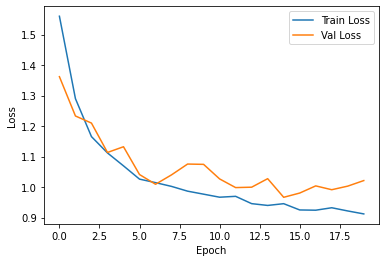

In [19]:
model4 = implement_neural_network(no_layers= 2, nodes_in_layer=[128,128], activation_function=activation,
                                  learning_rate=0.001,no_epoch=20, train_loader=train_loader, val_loader=val_loader)

In [20]:
eval_neural_network(model4, train_loader, "Training Metrics")
eval_neural_network(model4, test_loader, "Testing Metrics")
eval_neural_network(model4, val_loader, "Validation Metrics")

---------------------Training Metrics---------------------

Mean Accuracy Score across all categories: 0.66


Accuracy for class action : 0.604
Accuracy for class comedy : 0.679
Accuracy for class documentary : 0.783
Accuracy for class drama : 0.565
Accuracy for class horror : 0.756
Accuracy for class thriller : 0.4


              precision    recall  f1-score   support

           0       0.50      0.60      0.55      1084
           1       0.58      0.68      0.62      3317
           2       0.86      0.78      0.82      5364
           3       0.72      0.56      0.63      7031
           4       0.64      0.76      0.69      1771
           5       0.17      0.40      0.24       657

    accuracy                           0.66     19224
   macro avg       0.58      0.63      0.59     19224
weighted avg       0.70      0.66      0.67     19224

---------------------Testing Metrics---------------------

Mean Accuracy Score across all categories: 0.643


Accuracy for class action :

### 3.g Model Comparison

7. Compare the results and explain the effects of the number of hidden layers and number of neurons.

In [21]:
value_map = {"model 1": "One hidden layer with 64 neurons",
            "model 2" : "Two hidden layers with 64 neurons",
            "model 3" : "One hidden layer with 128 neurons",
            "model 4" : "Two hidden layer with 128 neurons"}

model1_acc, model1_acc_class = eval_neural_network(model1, test_loader, "Testing Metrics", True)
model2_acc, model2_acc_class = eval_neural_network(model2, test_loader, "Testing Metrics", True)
model3_acc, model3_acc_class = eval_neural_network(model3, test_loader, "Testing Metrics", True)
model4_acc, model4_acc_class = eval_neural_network(model4, test_loader, "Testing Metrics", True)

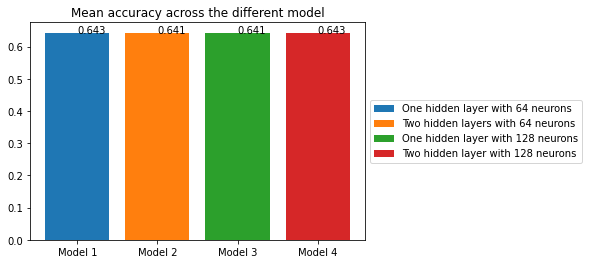

In [22]:
plt.bar("Model 1" ,model1_acc, label = value_map['model 1'])
plt.text("Model 1", model1_acc , str(model1_acc))

plt.bar('Model 2', model2_acc, label = value_map['model 2'])
plt.text("Model 2", model2_acc , str(model2_acc))

plt.bar('Model 3', model3_acc, label = value_map['model 3'])
plt.text("Model 3", model3_acc , str(model3_acc))

plt.bar('Model 4', model4_acc, label = value_map['model 4'])
plt.text("Model 4", model4_acc , str(model4_acc))

plt.title("Mean accuracy across the different model")
plt.legend(loc="center left",bbox_to_anchor =(1,0.5))
plt.show()

**The mean accuracy is similar across all the models. However model 1 and model 4 has the highest accuracy**

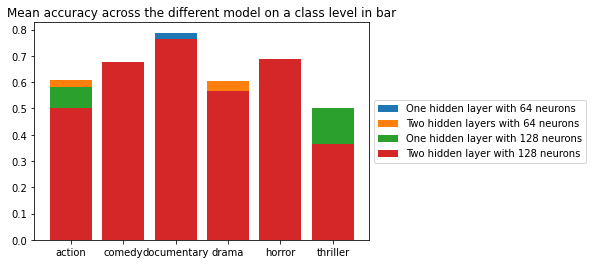

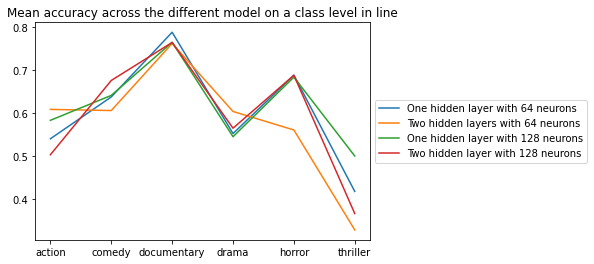

In [23]:
x = label_encoder.classes_

plt.bar(x,model1_acc_class, label = value_map['model 1'])
plt.bar(x,model2_acc_class, label = value_map['model 2'])
plt.bar(x,model3_acc_class, label = value_map['model 3'])
plt.bar(x,model4_acc_class, label = value_map['model 4'])
plt.title("Mean accuracy across the different model on a class level in bar")
plt.legend(loc="center left",bbox_to_anchor =(1,0.5))
plt.show()

plt.plot(x,model1_acc_class, label = value_map['model 1'])
plt.plot(x,model2_acc_class, label = value_map['model 2'])
plt.plot(x,model3_acc_class, label = value_map['model 3'])
plt.plot(x,model4_acc_class, label = value_map['model 4'])
plt.title("Mean accuracy across the different model on a class level in line")
plt.legend(loc="center left",bbox_to_anchor =(1,0.5))
plt.show()

**All the models performs reasonably close across the different categories with some deviation as seen in line plot and bar plot**

# 4. Image Recognition using Convolutional Neural Nets (CNNs)

Image Recognition using Convolutional Neural Nets (CNNs). In this exercise, you will implement a CNN using PyTorch to classify CIFAR10 images from 10 classes.

1) DownloadCIFAR10datasetfromhttps://www.cs.toronto.edu/ ̃kriz/cifar. html. There are 5 files for training sets and 1 file for test set. Use the first four training files for training, the 5-th training file for validation, and the test file for testing. The task is to classify a given image into one of 10 classes. Read the webpage/dataset and report the data statistics (number of instances in each class) for train, validation and test sets. The data for each image has three channels (R,G,B) and each pixel value is between 0 and 255. Normalize the images so that the maximum and minimum pixel values are between -1 and +1.

## 4.1 Data Prep

In [24]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [25]:
train_1 = unpickle('cifar/data_batch_1')
train_2 = unpickle('cifar/data_batch_2')
train_3 = unpickle('cifar/data_batch_3')
train_4 = unpickle('cifar/data_batch_4')
validation_dict = unpickle('cifar/data_batch_5')
test_dict = unpickle('cifar/test_batch')

In [26]:
train_dict = {}
train_dict[b'data'] = np.concatenate((train_1[b'data'], train_2[b'data'], 
                                      train_3[b'data'], train_4[b'data']), axis=0).reshape(-1,3,32,32)
train_dict[b'labels'] = ([*train_1[b'labels'], *train_2[b'labels'], 
    *train_3[b'labels'], *train_4[b'labels']])
train_dict[b'filenames'] = ([*train_1[b'filenames'], *train_2[b'filenames'], 
    *train_3[b'filenames'], *train_4[b'filenames']])

In [27]:
import torchvision.transforms as transforms

def create_normalized_tensors(images):
    transform_normalize = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    transformed_images = []
    for image in images:
        transformed_images.append(transform_normalize(image.reshape(32,32,3)).reshape(-1,3,32,32))
        
    result = torch.cat(transformed_images, dim=0) 
    return result
    

In [28]:
train_dict[b'data'] = create_normalized_tensors(train_dict[b'data'])
test_dict[b'data'] = create_normalized_tensors(test_dict[b'data'])
validation_dict[b'data'] = create_normalized_tensors(validation_dict[b'data'])

## CNN Implementation

2. Implement a CNN as follows: the first convolutional layer, gets a 3x32x32 image and applies 6 filters/kernels of size 5x5, followed by applying ReLu activation and then max-pooling with a window of size 2x2. The second convolution layer receives the input from the first layer and applies 16 filters/kernels of size 5x5, followed by applying ReLu activation and then max-pooling with a window of size 2x2. The results are then given to a feedforward NN, with three layers with 120 (with ReLu), 84 (with ReLu), 10 (you can use either softmax or no activation function) neurons. The loss function must be the cross-entropy loss. Use SGD optimizer, learning rate of 0.01 and momentum of 0.9. You need to choose the batch size, and the number of epochs.

In [29]:
train_images = train_dict[b'data']
train_target = torch.tensor(train_dict[b'labels'])

test_images = test_dict[b'data']
test_target = torch.tensor(test_dict[b'labels'])

validation_images = validation_dict[b'data']
validation_target = torch.tensor(validation_dict[b'labels'])

In [30]:
train_dataset = TensorDataset(train_images, train_target)
val_dataset = TensorDataset(test_images, test_target)
test_dataset = TensorDataset(validation_images, validation_target)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

In [31]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.pool_layer = nn.MaxPool2d(kernel_size=2)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool_layer(x)
        x = self.activation(self.conv2(x))
        x = self.pool_layer(x)
        x = x.view(-1, 16*5*5)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [32]:
# Define the loss function and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (pool_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (activation): ReLU()
)
Epoch 1: Train Loss 2.1405, Val Loss 1.8818
Found a new model with the lowest validation loss
Epoch 2: Train Loss 1.7423, Val Loss 1.6528
Found a new model with the lowest validation loss
Epoch 3: Train Loss 1.5772, Val Loss 1.5048
Found a new model with the lowest validation loss
Epoch 4: Train Loss 1.4700, Val Loss 1.4422
Found a new model with the lowest validation loss
Epoch 5: Train Loss 1.4046, Val Loss 1.4704
Epoch 6: Train Loss 1.3497, Val Loss 1.3705
Found a new model with the lowest validation loss
Epoch 7: Train Loss 1.2843, Val Loss 1.3000
Found a new model w

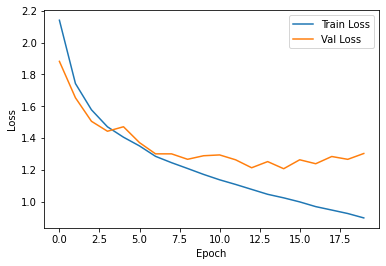

In [33]:
criterion = nn.CrossEntropyLoss()
model = CNN()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

print(model)

no_epoch = 20
train_losses = []
val_losses = []
best_val_loss = 99999999.0
best_model = None

for epoch in range(no_epoch):
    running_train_loss = 0.0
    running_val_loss = 0.0
    model.train()
    for i, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_losses.append(running_train_loss / len(train_loader))
    model.eval()
    with torch.no_grad():
        for i, (data, labels) in enumerate(val_loader):
            outputs = model(data)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
        val_losses.append(running_val_loss / len(val_loader))
    print(f"Epoch {epoch+1}: Train Loss {train_losses[-1]:.4f}, Val Loss {val_losses[-1]:.4f}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        print("Found a new model with the lowest validation loss")
        best_model = copy.deepcopy(model)

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [34]:
def eval_cnn(model, test_loader, name, return_arg = False):
    model.eval()
    with torch.no_grad():
        # for data, labels in test_loader
        outputs = model(test_loader.dataset.tensors[0])
        labels = test_loader.dataset.tensors[1]
        _, predicted = torch.max(outputs.data, 1)

        cm = metrics.confusion_matrix(predicted,labels)
        accuracies_in_class = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).diagonal()
        if return_arg:
            return np.round(metrics.accuracy_score(predicted,labels),3), accuracies_in_class
        else:
            print("---------------------"+ color.BOLD + name + color.END+"---------------------")
            print("\nMean Accuracy Score across all categories:", np.round(metrics.accuracy_score(predicted,labels),3))
            print("\n")
            for i in range(len(accuracies_in_class)):
                print("Accuracy for class "+ str(i) + " : "+ color.BOLD + str(np.round(accuracies_in_class[i],3)) + color.END)
            print("\n")
            print(metrics.classification_report(predicted, labels)) 

eval_cnn(best_model, test_loader, "Test")

---------------------Test---------------------

Mean Accuracy Score across all categories: 0.575


Accuracy for class 0 : 0.625
Accuracy for class 1 : 0.709
Accuracy for class 2 : 0.447
Accuracy for class 3 : 0.449
Accuracy for class 4 : 0.524
Accuracy for class 5 : 0.466
Accuracy for class 6 : 0.573
Accuracy for class 7 : 0.687
Accuracy for class 8 : 0.689
Accuracy for class 9 : 0.584


              precision    recall  f1-score   support

           0       0.63      0.62      0.63      1023
           1       0.61      0.71      0.66       877
           2       0.45      0.45      0.45       961
           3       0.35      0.45      0.39       795
           4       0.51      0.52      0.52       968
           5       0.50      0.47      0.48      1108
           6       0.68      0.57      0.62      1165
           7       0.61      0.69      0.65       872
           8       0.72      0.69      0.71      1052
           9       0.67      0.58      0.63      1179

    accuracy 